In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
import matplotlib.patches as patches
from pathlib import Path
import re

In [29]:

# ---- grids / mappings ----
NUM_SPACING = 29          # adjust if needed
NUM_WIDTH   = 10

spacing_um = np.linspace(2.0, 30.0, NUM_SPACING)   # 0→2 µm, 28→30 µm
width_um   = np.linspace(1.0, 10.0, NUM_WIDTH)     # 0→1 µm, 9→10 µm
doping_map = {
    0: "intrinsic",
    1: "1e15 cm^-3",
    2: "1e16 cm^-3",
    3: "1e17 cm^-3",
}
mode_map = {0: "A0", 1: "S0"}

def load_measure(path, value_name):
    # CSV has no header; five columns as described
    df = pd.read_csv(path, header=None, names=[
        "spacing_idx", "width_idx", "doping_idx", "mode_idx", value_name
    ])
    # attach physical labels (keep indices too)
    df["spacing_um"] = df["spacing_idx"].map({i:v for i,v in enumerate(spacing_um)})
    df["width_um"]   = df["width_idx"].map({i:v for i,v in enumerate(width_um)})
    df["doping"]     = df["doping_idx"].map(doping_map)
    df["mode"]       = df["mode_idx"].map(mode_map)
    return df

# Examples:
Qdf     = load_measure("./data/Q.csv",     "Q")
fdf     = load_measure("./data/freq.csv",  "freq_Hz")
k2em_df = load_measure("./data/k2_em.csv", "k2_em")   # unitless (e.g., 0.006 = 0.6%)
k2fd_df = load_measure("./data/k2_fd.csv", "k2_fd")
Lm_df   = load_measure("./data/Lm.csv",    "Lm_H")
Rm_df   = load_measure("./data/Rm.csv",    "Rm_ohm")
Cm_df   = load_measure("./data/Cm.csv",    "Cm_F")

# sanity peek
Qdf.head(10)
k2fd_df.count()
Qdf.count()

spacing_idx    2320
width_idx      2320
doping_idx     2320
mode_idx       2320
Q               109
spacing_um     2320
width_um       2320
doping         2320
mode           2320
dtype: int64

In [30]:
keys = ["spacing_idx","width_idx","doping_idx","mode_idx","spacing_um","width_um"]
df = (Qdf[keys+["Q"]]
      .merge(fdf[keys+["freq_Hz"]],   on=keys, how="inner")
      .merge(k2em_df[keys+["k2_em"]], on=keys, how="inner")
     .merge(k2fd_df[keys+["k2_fd"]],   on=keys, how="inner"))
# then use the plotting code from the merged-df section
df.head()

,spacing_idx,width_idx,doping_idx,mode_idx,spacing_um,width_um,Q,freq_Hz,k2_em,k2_fd
0,0,0,0,0,2.0,1.0,NaN,NaN,NaN,NaN
1,0,0,0,1,2.0,1.0,NaN,NaN,NaN,NaN
2,0,0,1,0,2.0,1.0,NaN,NaN,NaN,NaN
3,0,0,1,1,2.0,1.0,NaN,NaN,NaN,NaN
4,0,0,2,0,2.0,1.0,NaN,NaN,NaN,NaN


In [22]:
undamped_data = {
    "lambda": [7.000E-06,8.000E-06,9.000E-06,1.000E-05,1.100E-05,1.200E-05,1.300E-05,1.400E-05,1.50E-05,1.60E-05,2.00E-05,2.60E-05,4.00E-05,8.00E-05],
    "hGan/Lambda": [0.63, 0.55, 0.49, 0.440, 0.400, 0.367, 0.338,0.314,0.293,0.275,0.220,0.169, .110,.055],
    "Antisymmetric ksq%": [0.055, 0.081, 0.103, 0.121, 0.134, 0.143, 0.148,0.150 ,0.152,0.149, 0.134,0.105,.064,.031],
    "Symmetric ksq%": [0.275, 0.358, 0.448, 0.533, 0.602, 0.643, 0.652,0.641,0.624,0.604,.56,.552,0.567,.576]
}
undamped_df = pd.DataFrame(undamped_data)

The app didn't save $k^2 = 1-f_s^2/f_p^2$ but we can find it with the raw data. This next cell looks for only W02 and Nd1e5 configurations, because I thought the `IMEC_JA_fresh_erik.mph` file restriced width to 2 $\mu$ m, but in fact the restriction was width = spacing = $\lambda/4$

In [20]:

# Directory containing all CSVs
data_dir = Path("./data/freq_domain/")  # change to your directory

results = []
S0_count = 0
A0_count = 0
skip_count = 0
for csv_path in data_dir.glob("*.csv"):
    fname = csv_path.name

    # Only process those containing W02 and Nd1e5
    if "W02" not in fname or "Nd1e15" not in fname:
        #print(f"skipping {fname} ")
        skip_count = skip_count + 1
        continue

    # Identify mode (S0 or A0)
    m_mode = re.search(r'(S0|A0)(?=\.csv$)', fname)
    if m_mode:
        mode = m_mode.group(1)
        if mode == "S0":
            S0_count = S0_count + 1
        else:
            A0_count = A0_count + 1
    else:
        continue # skip if neither mode found

    # Extract the spacing number after 'S' but before 'W'
    # e.g. S02W02Nd1e15S0.csv -> spacing = 2
    m = re.search(r"S(\d+)W", fname)
    if not m:
        
        continue
    spacing = float(m.group(1))

    # Calculate λ = 2*(spacing + width)
    width = 2.0
    lam = 2 * (spacing + width)

    # Load data
    df2 = pd.read_csv(csv_path, header=None)

    def calc_k2(df):
        # Extract frequency and admittance columns
        freq = df.iloc[:, 0].to_numpy()        # column 1 (1-indexed)
        magY = df.iloc[:, 4].to_numpy()        # column 5 (1-indexed)

        # Find fs (max admittance) and fp (min admittance)
        fs = freq[np.argmax(magY)]
        fp = freq[np.argmin(magY)]

        # Compute k^2
        ksq = (1 - (fs**2) / (fp**2))*100
        return ksq
    
    ksq = calc_k2(df2)

    # Store result
    results.append({
        'lambda': lam,
        'spacing': spacing,
        'hGaN/lambda': 4.4 / lam,
        f"ksq_{mode}": ksq
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Merge S0 and A0 results on lambda_inv
#results_df = results_df.groupby("lambda_inv").first().reset_index()
ksq_df = results_df.pivot_table(index=['lambda','spacing','hGaN/lambda'],
                                 values=['ksq_S0','ksq_A0'], aggfunc='first').reset_index()
#ksq_df.rename(columns={'lambda_r':'lambda'}, inplace=True)
# Display and save
print(ksq_df.sort_values("spacing"))
#results_df.to_csv("ksq_results.csv", index=False)
print(f"S0 count: {S0_count}, A0 count: {A0_count}, skipped: {skip_count}")

   lambda  spacing  hGaN/lambda    ksq_A0    ksq_S0
0     8.0      2.0     0.550000       NaN  0.365834
1    10.0      3.0     0.440000  0.137211  0.516068
2    12.0      4.0     0.366667  0.155242  0.591339
3    14.0      5.0     0.314286       NaN  0.560284
4    20.0      8.0     0.220000  0.129994       NaN
5    24.0     10.0     0.183333  0.107143  0.405988
6    28.0     12.0     0.157143  0.087894       NaN
7    34.0     15.0     0.129412       NaN  0.346086
8    44.0     20.0     0.100000  0.044564  0.296927
9    56.0     26.0     0.078571       NaN  0.245330
S0 count: 8, A0 count: 6, skipped: 90


Gather k^2 entries where spacing and width track closest to $\lambda/4$ (spacing equals width). This enables comparison of new app data to Fig-3-4 of Popa Thesis where the geometry is contrained 

In [ ]:
# Gather k^2 entries where spacing and width track closest to \lambda/4 (spacing approximately equals width).
closest_lambda_quarter = df[(df['k2_fd'].notna()) & (df['doping_idx'] == Nd_idx)].copy()
closest_lambda_quarter['lambda_um'] = 2.0 * (closest_lambda_quarter['spacing_um'] + closest_lambda_quarter['width_um'])
closest_lambda_quarter['hGaN/lambda'] = hGaN_um / closest_lambda_quarter['lambda_um']
closest_lambda_quarter['width_spacing_err'] = (closest_lambda_quarter['width_um'] - closest_lambda_quarter['spacing_um']).abs()

min_err = closest_lambda_quarter['width_spacing_err'].min()
mode_label_map = {0: 'ksq_A0', 1: 'ksq_S0'}
lambda_quarter_df = (
    closest_lambda_quarter[closest_lambda_quarter['width_spacing_err'] == min_err]
    .assign(mode_label=lambda frame: frame['mode_idx'].map(mode_label_map))
    .pivot_table(index='hGaN/lambda', columns='mode_label', values='k2_fd', aggfunc='first')
    .reset_index()
    .reindex(columns=['hGaN/lambda', 'ksq_A0', 'ksq_S0'])
    .dropna(subset=['ksq_A0', 'ksq_S0'])
    .sort_values('hGaN/lambda')
)

lambda_quarter_df
#to do: add width and spacing columns

mode_label,hGaN/lambda,ksq_A0,ksq_S0
1,0.183333,0.114196,0.552328
2,0.220000,0.133699,0.561619
5,0.550000,0.081132,0.358131


Text(0, 0.5, '$k^2$ [%]')

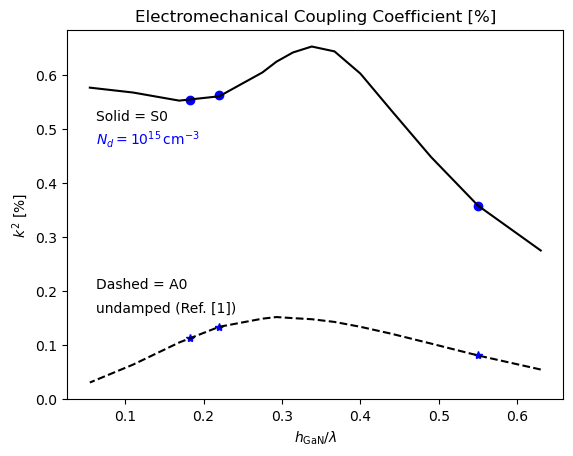

In [ ]:
hGaN_um   = 4.4
width_sel = 2.0
Nd_idx    = 1          # 1e15 cm^-3
modes     = {0:"A0", 1:"S0"}
style     = {0:"--",  1:"-"}   # A0 dashed, S0 solid

# keep only the relevant slice
dfA0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()

# NaN/Inf guard for each plot
df_k2_A0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
df_k2_S0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
df_k2_A0["lambda_um"]     = 2.0*(df_k2_A0["spacing_um"] + df_k2_A0["width_um"])
df_k2_A0['hGaN/lambda'] = hGaN_um / df_k2_A0["lambda_um"]
df_k2_S0["lambda_um"]     = 2.0*(df_k2_S0["spacing_um"] + df_k2_S0["width_um"])
df_k2_S0['hGaN/lambda'] = hGaN_um / df_k2_S0["lambda_um"]
fig, ax = plt.subplots()

# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid

ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq_A0"], color='b', linestyle='none', marker='*')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq_S0"], color='b', linestyle='none', marker='o')#, label = r'$k^2 [\%]$')

ax.plot(undamped_df["hGan/Lambda"], undamped_df["Antisymmetric ksq%"], color='k', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(undamped_df["hGan/Lambda"], undamped_df["Symmetric ksq%"], color='k', linestyle='-')#, label = r'$k^2 [\%]$')
# Annotations
# Nd annotations in figure coordinates (left, midway up)

ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.15, 0.65), xycoords='figure fraction', color='b', fontsize=10)
ax.annotate('undamped (Ref. [1])', xy=(0.15, 0.3), xycoords='figure fraction', color='k', fontsize=10)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%]')
ax.set_ylabel(r'$k^2$ [%]')

Old plot for comparison 

Note this was with geometry that always had width = $\lambda / 4 $

<img src="SavedFigs/ksq_wdth_lmbdaOver_4.png" alt="Test setup" width="420">



### check eigenmode $k^2$ (doesn't work)

Text(0, 0.5, '$k^2$ [%]')

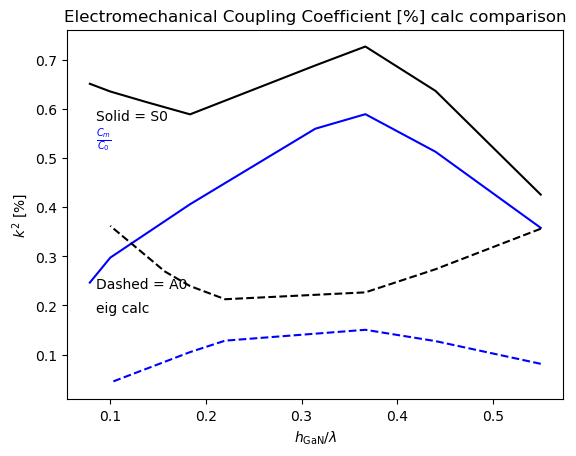

In [ ]:

# NaN/Inf guard for each plot
df_k2_A0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
df_k2_S0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
df_k2_A0["lambda_um"]     = 2.0*(df_k2_A0["spacing_um"] + df_k2_A0["width_um"])
df_k2_A0['hGaN/lambda'] = hGaN_um / df_k2_A0["lambda_um"]
df_k2_S0["lambda_um"]     = 2.0*(df_k2_S0["spacing_um"] + df_k2_S0["width_um"])
df_k2_S0['hGaN/lambda'] = hGaN_um / df_k2_S0["lambda_um"]


fig, ax = plt.subplots()
# curves of Nd = 1e16 are red, with red text stating Nd = 1e16
#curves of Nd = 1e15 are blue, with blue text stating Nd = 1e15
# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid

ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['k2_fd'], color='b', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['k2_fd'], color='b', linestyle='-')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['k2_em'], color='k', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['k2_em'], color='k', linestyle='-')#, label = r'$k^2 [\%]$')
# Annotations
# Nd annotations in figure coordinates (left, midway up)

ax.annotate(r'$\frac{C_m}{C_0}$', xy=(0.15, 0.65), xycoords='figure fraction', color='b', fontsize=10)
ax.annotate('eig calc', xy=(0.15, 0.3), xycoords='figure fraction', color='k', fontsize=10)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)


ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%] calc comparison')
ax.set_ylabel(r'$k^2$ [%]')

### plot $f\cdot Q$ product for $N_d = 10^{15}$ at width = $2\mu m$ 

Text(0, 0.5, '$f\\cdot Q$ Product $[\\cdot 10^{11}]$')

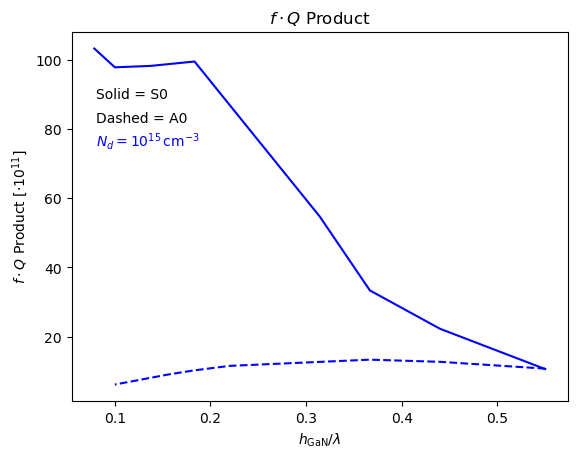

In [ ]:


# NaN/Inf guard for each plot
df_Q_A0 = dfA0[np.isfinite(dfA0['Q'])].copy()
df_Q_S0 = dfS0[np.isfinite(dfS0['Q'])].copy()
# derive axes
df_Q_A0["lambda_um"]     = 2.0*(df_Q_A0["spacing_um"] + df_Q_A0["width_um"])
df_Q_A0['hGaN/lambda'] = hGaN_um / df_Q_A0["lambda_um"]
df_Q_S0["lambda_um"]     = 2.0*(df_Q_S0["spacing_um"] + df_Q_S0["width_um"])
df_Q_S0['hGaN/lambda'] = hGaN_um / df_Q_S0["lambda_um"]


fig, ax = plt.subplots()
# curves of Nd = 1e16 are red, with red text stating Nd = 1e16
#curves of Nd = 1e15 are blue, with blue text stating Nd = 1e15
# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid
ax.plot(df_Q_A0['hGaN/lambda'], df_Q_A0['Q']*df_Q_A0['freq_Hz']/1e11, color='b', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(df_Q_S0['hGaN/lambda'], df_Q_S0['Q']*df_Q_S0['freq_Hz']/1e11, color='b', linestyle='-')#, label = r'$k^2 [\%]$')

# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.15, 0.65), xycoords='figure fraction', color='b', fontsize=10)
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title(r'$f\cdot Q$ Product')
ax.set_ylabel(r'$f\cdot Q$ Product $[\cdot 10^{11}]$')

### plot $k^2$ and $Q$ as width varies for a fixed $\lambda$

Text(0, 0.5, '$Q$')

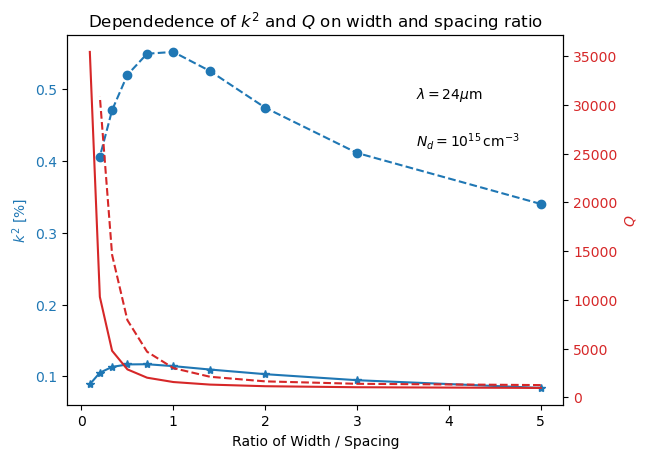

In [31]:
lambda_sel = 24.0
Nd_idx    = 1          # 1e15 cm^-3
df["lambda_um"]     = 2.0*(df["spacing_um"] + df["width_um"])
# keep only the relevant slice
dfA0 = df[(df["lambda_um"]==lambda_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["lambda_um"]==lambda_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()

# NaN/Inf guard for each plot
dfA0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
dfS0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
dfA0['w_s_ratio'] = dfA0["width_um"] / dfA0["spacing_um"]
dfS0['w_s_ratio'] = dfS0["width_um"] / dfS0["spacing_um"]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot( dfA0['w_s_ratio'], dfA0['k2_fd'], color="tab:blue", marker='*')
ax2.plot( dfA0['w_s_ratio'], dfA0['Q'], color = "tab:red")
ax.plot( dfS0['w_s_ratio'], dfS0['k2_fd'], color="tab:blue", linestyle='--',marker='o')
ax2.plot( dfS0['w_s_ratio'], dfS0['Q'], color = "tab:red", linestyle='--')
ax.annotate(r'$\lambda= 24\mu$m', xy=(0.65, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.65, 0.65), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'Ratio of Width / Spacing')
ax.tick_params(axis="y", labelcolor="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax.set_title(r'Dependedence of $k^2$ and $Q$ on width and spacing ratio')
ax.set_ylabel(r'$k^2$ [%]', color="tab:blue")
ax2.set_ylabel(r'$Q$', color="tab:red")
#to do: add product of two curves on a third axis that isn't shown, but label peak value on the plot
#and / or create a new plot with same x axis, left y is k^2Q, right is fQ

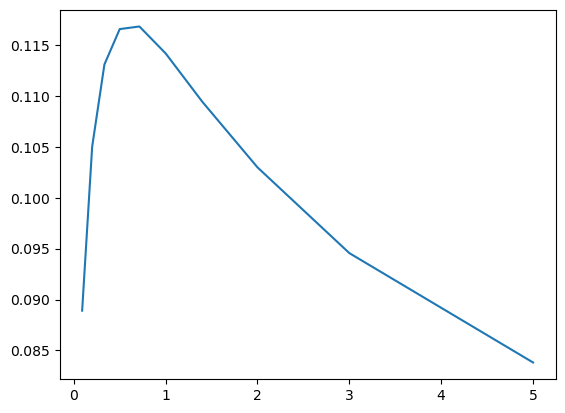

In [32]:
fig, ax = plt.subplots()

ax.plot( dfA0['w_s_ratio'], dfA0['k2_fd'], color="tab:blue")

np.float64(0.0)